# Dimensionality Reduction on MNIST Digit Data
In this example, we do dimensionality reduction on the MNIST digits dataset. We will use PCA and tSNE to do so.

## Preparations

### Load Libraries
As always, we first load the relevant libraries:

In [17]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
!pip install tensorflow

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler, StandardScaler

  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 38.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 37.7 MB/s eta 0:00:00 0:00:01
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 40.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.9 MB/s eta 0:00:00


In [20]:
# import dataset
from keras.datasets import mnist

In [21]:
np.random.seed(42)

### Prepare data
The MNIST dataset is available via tensorflow. It consists of grayscale images of size 28 x 28. The pixel values are in the range between 0 and 255. We don't actually need any validation and test data here, but we keep the same split as we had in the classification examples.

In [33]:
# Load data:
(train_val_images, train_val_labels), (test_images, test_labels) = mnist.load_data()

# Bring pixel values to the range 0...1 by divin image data:
train_val_images = train_val_images / 255.0
test_images = test_images / 255.0

# Split into training / validation
train_images_all, val_images, train_labels_all, val_labels = train_test_split(train_val_images, train_val_labels,
                                                                              test_size=0.20, random_state=42)

In [34]:
train_images_all.shape

(48000, 28, 28)

To reduce the computing time, we limit ourselves to `Nimages` randomly sampled images from train dataset:

In [35]:
Nimages = 20000
indexes = np.random.randint(0, train_images_all.shape[0], size=Nimages)
images = train_images_all[indexes]
labels = train_labels_all[indexes]

### Flatten Images
In order to be able to work with PCA, we need to flatten the images first. Doing so, we will get one row representing each image:

In [25]:
images.shape

(20000, 28, 28)

In [26]:
images_flat = images.reshape(Nimages, -1)

In [27]:
images_flat.shape

(20000, 784)

## Principal Component Analysis
Now we are ready to do principal component analysis:

In [28]:
pca_MNIST = PCA(n_components=500).fit(images_flat)

Now we look at the cumulative ratio of explained variance for a varying number of components:

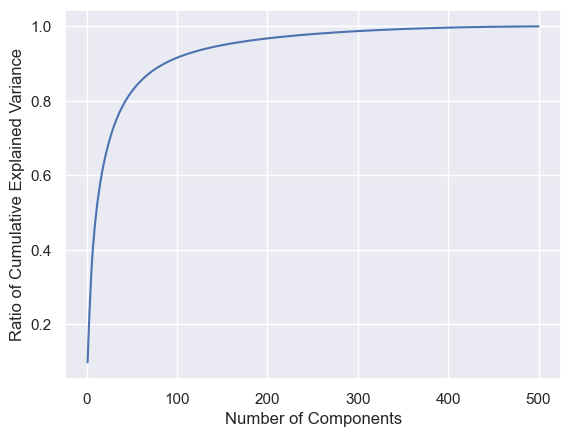

In [29]:
sns.set_theme()
sns.lineplot(x=range(1, len(pca_MNIST.explained_variance_ratio_)+1), y=np.cumsum(pca_MNIST.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Cumulative Explained Variance')
plt.show()

We can also visualize the individual digit images by their coordinates in the first two principal components:

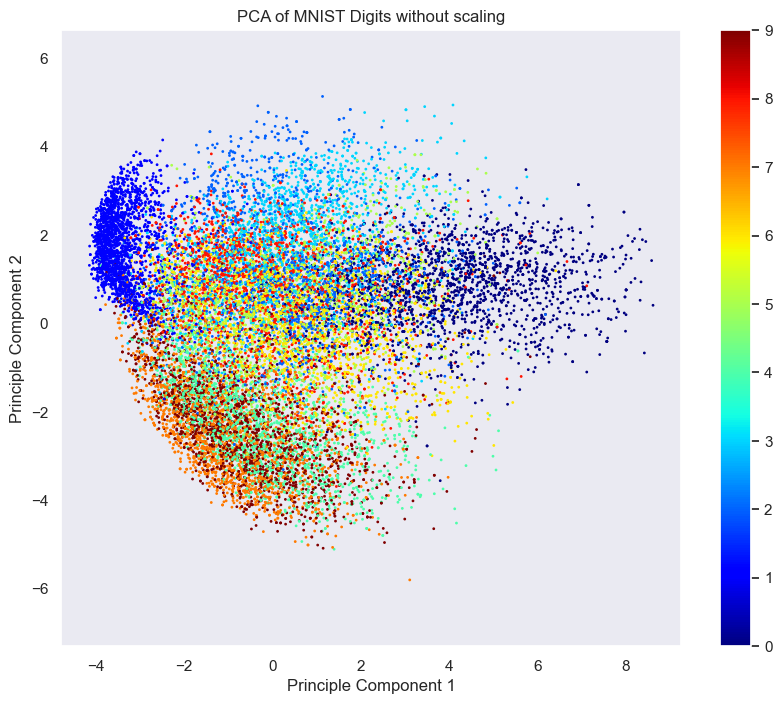

In [30]:
mnist_embedded_pca = pca_MNIST.transform(images_flat)
plt.figure(figsize=(10, 8))
plt.scatter(mnist_embedded_pca[:,0], mnist_embedded_pca[:,1], c = labels, s=1, cmap='jet')
plt.colorbar()
plt.grid(False)
plt.axis('equal')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('PCA of MNIST Digits without scaling')
plt.show()

Obviously, this is not very helpful to distinguish the individual digits.

Let's also look at how the components look like - i.e., we try to visualize the coefficients of the principal component directions:

In [31]:
pca_MNIST_components = pca_MNIST.components_

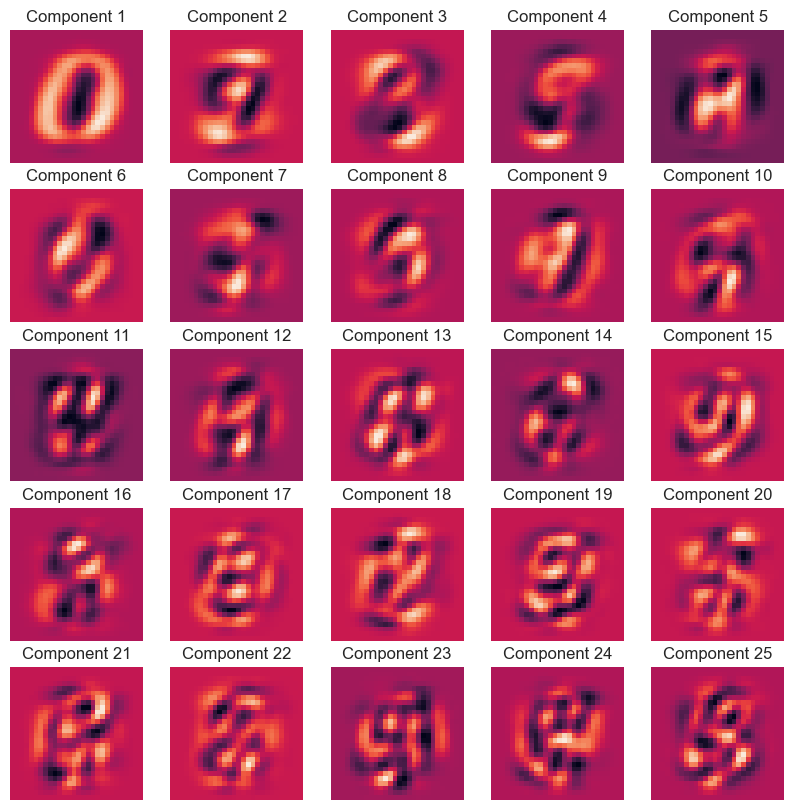

In [32]:
# plot the 25 most important components:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = pca_MNIST_components[i, :]
    plt.imshow(image.reshape(28, 28))
    plt.title('Component ' + str(i+1))
    plt.axis('off')
    
plt.show()

Some of these components can be well interpreted: For example, the first component looks pretty much like a 0. This is also what we see when looking at the plot above, where we see 0 represented by a positive coordinate in the direction of the first component, and a coodinate near 0 for the second component. Many of these components, however, cannot be interpreted.

## tSNE
Next, we will look at tSNE, as we have seen that PCA does not help us so much to embed the digit images in a lower-dimensional space. Note that we have to provide the number of target dimensions right from the start, and tSNE will find the best possible neighborhood embedding using the given number of dimensions - leaving out a few dimensions later on would render the representation incomplete and useless!

Calling tSNE in Python is straitforward:

In [15]:
mnist_embedded_tsne = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(images_flat)

Note that there is no `transform` function for tSNE, as tSNE cannot be learned on a first dataset and then be applied to a second dataset.

Let's look at the representation of our digit images in the project space of tSNE:

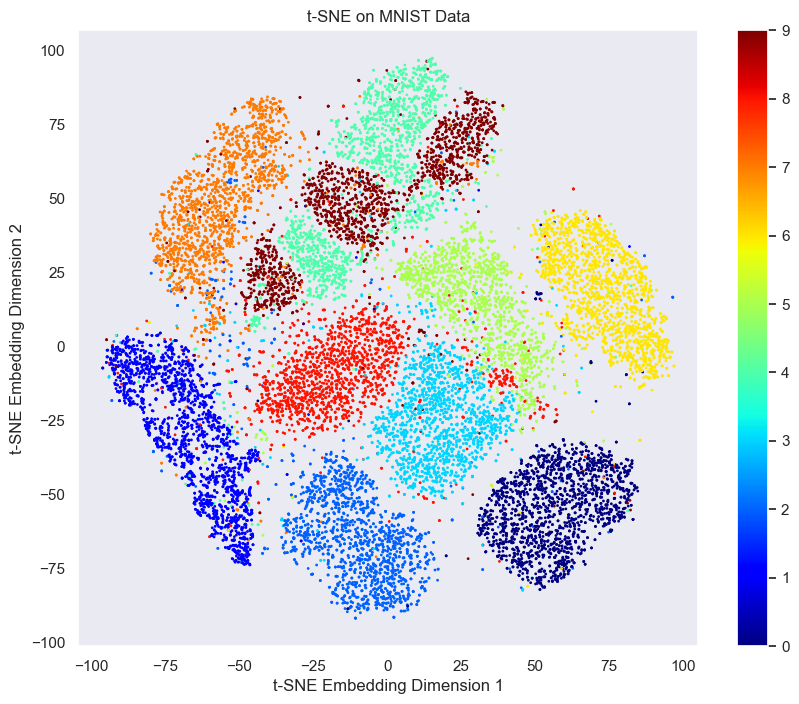

In [16]:
plt.figure(figsize=(10, 8))
plt.scatter(mnist_embedded_tsne[:, 0], mnist_embedded_tsne[:, 1], c = labels, s=1, cmap='jet')
plt.colorbar()
plt.grid(False)
plt.axis('equal')
plt.xlabel('t-SNE Embedding Dimension 1')
plt.ylabel('t-SNE Embedding Dimension 2')
plt.title('t-SNE on MNIST Data')
plt.show()

## Optional Exercise: Impact of Scaling

**EXERCISE**: Above, we have **not** used any scaling. Do you have an idea why? Do PCA and tSNE on scaled data, and compare the results. 

**SOLUTION**: We branch off before doing the PCA and scale the images first:

### Scaling

In [17]:
image_SS = StandardScaler().fit(images_flat)
images_sc_flat = image_SS.transform(images_flat)

The shape of the data is still the same:

In [18]:
images_sc_flat.shape

(20000, 784)

### PCA
Now we do PCA - just as before, except that we run it on `images_sc_flat` instead of `images_flat`:

In [19]:
pca_MNIST_sc = PCA(n_components=500).fit(images_sc_flat)

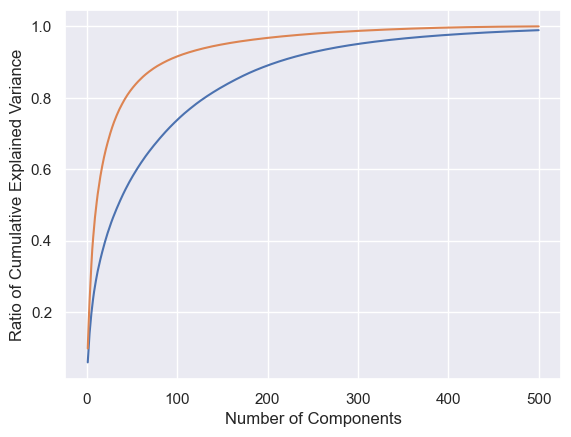

In [20]:
plt.plot(range(1, len(pca_MNIST_sc.explained_variance_ratio_)+1), np.cumsum(pca_MNIST_sc.explained_variance_ratio_), label='scaled')
plt.plot(range(1, len(pca_MNIST.explained_variance_ratio_)+1), np.cumsum(pca_MNIST.explained_variance_ratio_), label='raw')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Cumulative Explained Variance')
plt.show()

Next we plot a scatterplot of the digits in the principal components of the scaled data. For comparison, we show the same plot as obtained on the raw data on the right side:

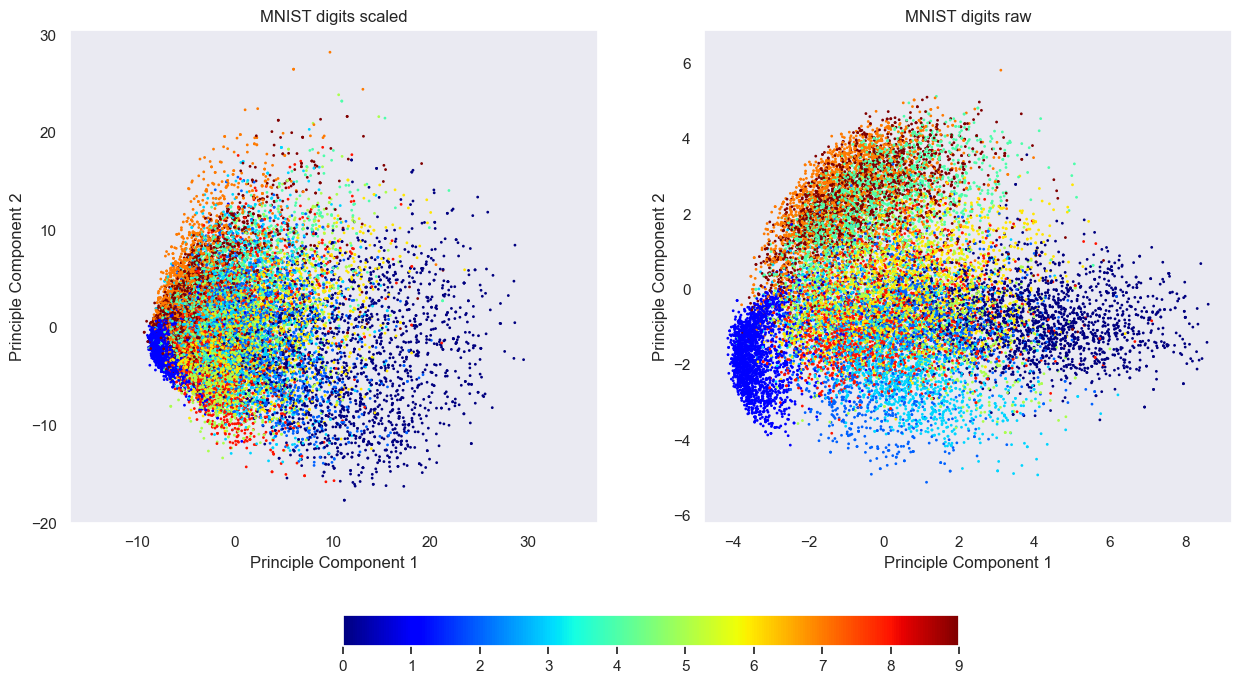

In [21]:
mnist_sc_embedded_pca = pca_MNIST_sc.transform(images_sc_flat)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
s0 = axs[0].scatter(mnist_sc_embedded_pca[:,0], mnist_sc_embedded_pca[:,1], c = labels, s=1, cmap='jet')
axs[0].grid(False)
axs[0].axis('equal')
axs[0].set_xlabel('Principle Component 1')
axs[0].set_ylabel('Principle Component 2')
axs[0].set_title('MNIST digits scaled')

s1 = axs[1].scatter(mnist_embedded_pca[:,0], mnist_embedded_pca[:,1], c = labels, s=1, cmap='jet')
axs[1].grid(False)
axs[1].axis('equal')
axs[1].set_xlabel('Principle Component 1')
axs[1].set_ylabel('Principle Component 2')
axs[1].set_title('MNIST digits raw')

fig.colorbar(s1, ax=axs, orientation='horizontal', fraction=.05)
plt.show()

### tSNE
As above, we adapt the code for tSNE to transform the scaled input data, and we plot the two embeddings next to each other:

In [22]:
mnist_sc_embedded_tsne = TSNE(n_components=2, random_state=42, perplexity=40).fit_transform(images_sc_flat)

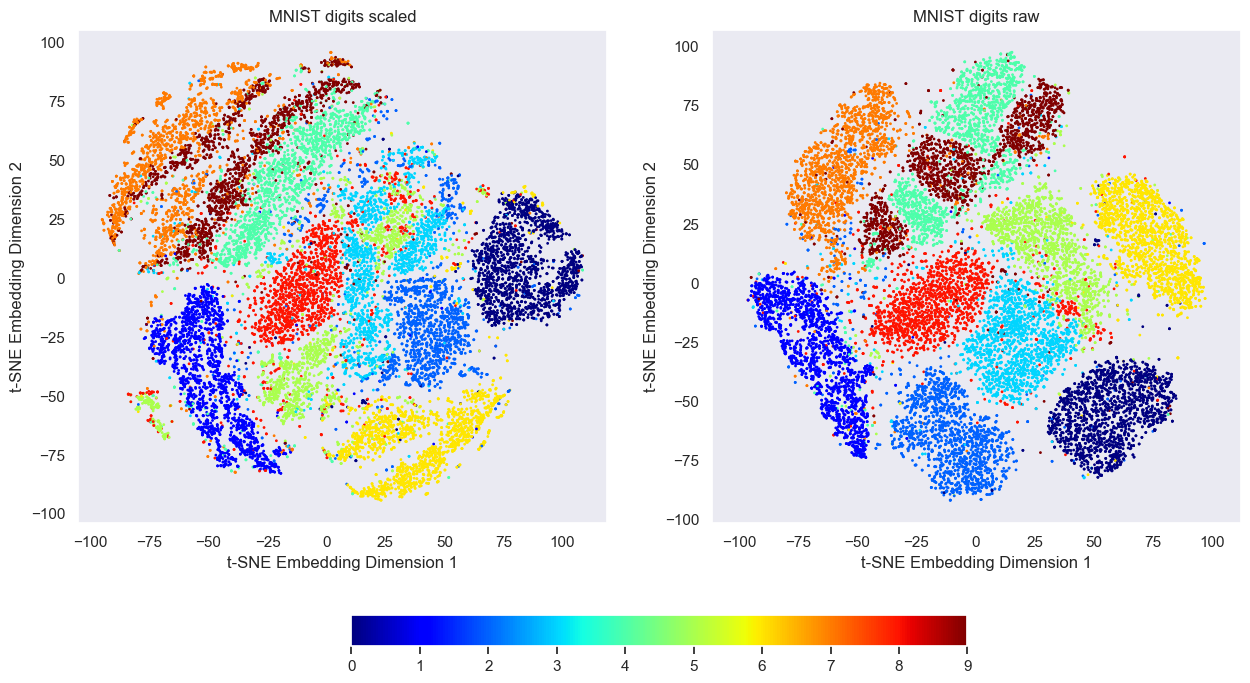

In [23]:
mnist_sc_embedded_pca = pca_MNIST_sc.transform(images_sc_flat)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
s0 = axs[0].scatter(mnist_sc_embedded_tsne[:,0], mnist_sc_embedded_tsne[:,1], c = labels, s=1, cmap='jet')
axs[0].grid(False)
axs[0].axis('equal')
axs[0].set_xlabel('t-SNE Embedding Dimension 1')
axs[0].set_ylabel('t-SNE Embedding Dimension 2')
axs[0].set_title('MNIST digits scaled')

s1 = axs[1].scatter(mnist_embedded_tsne[:,0], mnist_embedded_tsne[:,1], c = labels, s=1, cmap='jet')
axs[1].grid(False)
axs[1].axis('equal')
axs[1].set_xlabel('t-SNE Embedding Dimension 1')
axs[1].set_ylabel('t-SNE Embedding Dimension 2')
axs[1].set_title('MNIST digits raw')

fig.colorbar(s1, ax=axs, orientation='horizontal', fraction=.05)
plt.show()

### Interpretation

In [24]:
images.shape

(20000, 28, 28)

In [25]:
images_sc = images_sc_flat.reshape(Nimages, 28, 28)

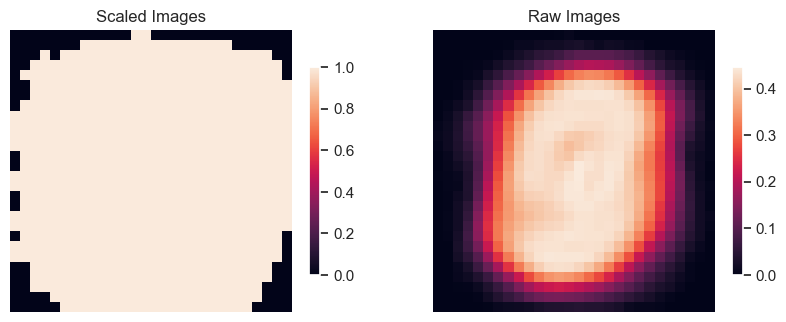

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

images_sc_std = np.std(images_sc, axis=0)
cset0 = axs[0].imshow(images_sc_std)
axs[0].set_title('Scaled Images')
# axs[0].colorbar()
axs[0].axis('off')
fig.colorbar(cset0, ax=axs[0], location='right', shrink=0.45)

images_std = np.std(images, axis=0)
cset1 = axs[1].imshow(images_std)
axs[1].set_title('Raw Images')
axs[1].axis('off')
fig.colorbar(cset1, ax=axs[1], location='right', shrink=0.45)

plt.show()    

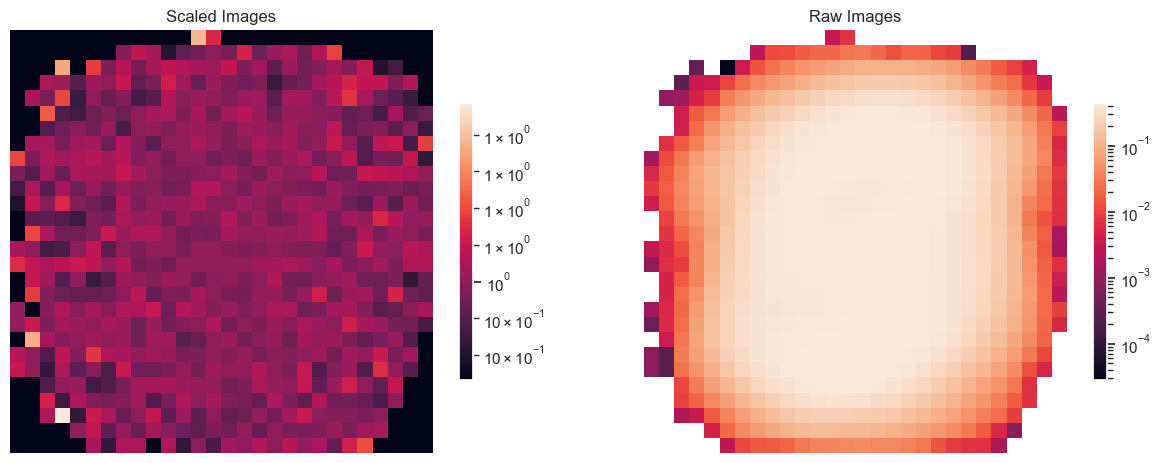

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

images_sc_std = np.std(images_sc, axis=0)
cset0 = axs[0].imshow(images_sc_std, norm='log')
axs[0].set_title('Scaled Images')
# axs[0].colorbar()
axs[0].axis('off')
fig.colorbar(cset0, ax=axs[0], location='right', shrink=0.45)

images_std = np.std(images, axis=0)
cset1 = axs[1].imshow(images_std, norm='log')
axs[1].set_title('Raw Images')
axs[1].axis('off')
fig.colorbar(cset1, ax=axs[1], location='right', shrink=0.45)

plt.show()  

In [28]:
**Comment**: 
The differences are quite large:
* Looking at the cumulative explained variance 

SyntaxError: invalid syntax (653274059.py, line 1)